<a href="https://colab.research.google.com/github/angelotc/FriedmanIsolationForest/blob/main/FriedmanIsoForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
from sklearn.datasets import make_friedman1
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn import model_selection 
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt


In [93]:
# Helper functions

def add_y_as_feature(X,y):
  y = np.reshape(y,(len(y),1))
  return np.concatenate((X,y), axis=1)

def contaminate_y(y1, y2, percentage):
    '''
    Parameters:
    y1 - y dataframe to contaminate
    y2 - y dataframe that is contaminated
    percentage - takes a float value as a percentage. It will add this percentage of the contaminated rows into y1. 
    Returns:
    y1 + percentage of the contaminated rows in y2
    '''
    return y1[:int(len(y1)*(1-percentage))].append(y2[:int(len(y2)*percentage)])
def copy_and_add_noise_rows(df,):
  pass

In [71]:
# Create synthetic dataset using make_friedman1. N = 100k

X1, y1 = make_friedman1(
    n_samples=1000, n_features = 5 , random_state=1)


# Create another synthetic dataset with noise.
X2, y2 = make_friedman1(
    n_samples=1000, n_features = 5, random_state=1, noise=20,)

y2 += 30

x_cols = ["x1", "x2", "x3", "x4", "x5"]

In [72]:
X1 = pd.DataFrame(X1, columns = ["x1", "x2", "x3", "x4", "x5"])
y1 = pd.DataFrame(y1, columns = ["y1"])
X2 = pd.DataFrame(X2, columns = ["x1", "x2", "x3", "x4", "x5"])
y2 = pd.DataFrame(y2, columns = ["y1"])

X1.head(),X2.head(),y1.head(),y2.head()

(         x1        x2        x3        x4        x5
 0  0.417022  0.720324  0.000114  0.302333  0.146756
 1  0.092339  0.186260  0.345561  0.396767  0.538817
 2  0.419195  0.685220  0.204452  0.878117  0.027388
 3  0.670468  0.417305  0.558690  0.140387  0.198101
 4  0.800745  0.968262  0.313424  0.692323  0.876389,
          x1        x2        x3        x4        x5
 0  0.417022  0.720324  0.000114  0.302333  0.146756
 1  0.092339  0.186260  0.345561  0.396767  0.538817
 2  0.419195  0.685220  0.204452  0.878117  0.027388
 3  0.670468  0.417305  0.558690  0.140387  0.198101
 4  0.800745  0.968262  0.313424  0.692323  0.876389,
           y1
 0  16.852205
 1   7.678848
 2  18.513197
 3  10.164178
 4  18.487972,
           y1
 0  69.062363
 1  52.705935
 2  52.870540
 3  24.553838
 4  49.895130)

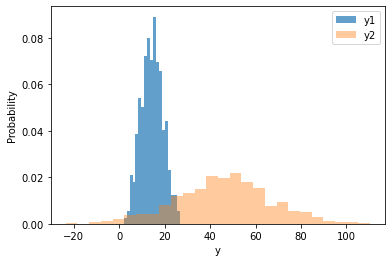

In [74]:
from matplotlib import pyplot as plt
n_bins = len(X)//100
# We can set the number of bins with the `bins` kwarg

plt.xlabel('y')
plt.ylabel('Probability')

# bins = compute_histogram_bins(y1, 1.0)
plt.hist(y1, bins='auto', alpha=0.7, density = True, label='y1')
plt.hist(y2, bins='auto', alpha=0.4, density = True, label='y2')
plt.legend(loc='upper right')
plt.show()


In [97]:
def contaminate_y(y1, y2, percentage):
    '''
    Parameters:
    y1 (df) - y dataframe to contaminate
    y2  (df) - y dataframe that is contaminated (has noise)
    percentage (float) - Takes a float value (0,1) as a percentage. It will add remove this percentage of rows from y1, and add this percentage of the contaminated rows from y2 into y1. 
    For example, it will take out 5 of the rows out of x1
    
    Returns:
    y1 + percentage of the contaminated rows in y2 (df)
    '''
    return y1[:int(len(y1)*(1-percentage))].append(y2[:int(len(y2)*percentage)])

y1 = contaminate_y(y1,y2,0.05)

In [98]:
# Instantiate model -> fit -> predict using test set.
# Note on contamination parameter: This is a parameter that the algorithm is quite sensitive to; it refers to the expected 
# proportion of outliers in the data set. This is used when fitting to define the threshold on the scores of the samples.

clf = IsolationForest(max_samples=0.5, contamination = 0.05, bootstrap = False )
clf.fit(y1)
y_pred_test = clf.predict(y2)

In [99]:
pd.DataFrame(y_pred_test).value_counts()

-1    867
 1    133
dtype: int64

The above says that only 2 of the 10k test set samples are found as outliers. Of course, these 2 are false-positives, since they are  generated by the formula of Friedman formula:


y(X) = 10 * sin(pi * X[:, 0] * X[:, 1]) + 20 * (X[:, 2] - 0.5) ** 2 + 10 * X[:, 3] + 5 * X[:, 4] + noise * N(0, 1).

##Everything below is experimental:

In [ ]:
# Increasing features from 5->50? Only first 5 variables are correlated, so what if we add more independent variables. Would that change our predictions?
for i in range (5,10):
  X, y = make_friedman1(
    n_samples=100000, n_features = i,  noise=0.1, random_state=1)
  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.1, random_state=42)
  clf = IsolationForest(max_samples='auto', contamination = 0)
  clf.fit(X_train)
  y_pred_test = clf.predict(X_test)
  print(i, pd.DataFrame(y_pred_test).value_counts())

In [ ]:
# Doesn't look like it!